In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import datetime as dt

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from gaussian_process import *

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv("../Metro_Interstate_Traffic_Volume.csv")
df['date_time'] = pd.to_datetime(df['date_time'])
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month
df['year'] = df['date_time'].dt.year
df['is_holiday'] = (~ df['holiday'].isnull()).astype(int)
df['time_step'] = (df['date_time'] - pd.Timestamp("2012-10-02 09:00:00")) // pd.Timedelta(hours=1) # hours since 2012-10-20 9am

# Training data
df_train = df[df['date_time'].dt.year.isin([2016, 2017])] # 2016, 2016 as training data
df_test = df[df['date_time'].dt.year.isin([2018])] # 2018 for validation

# only include time data
X_train = df_train[['time_step']]
X_test = df_test[['time_step']]

y_train = df_train['traffic_volume']
y_test = df_test['traffic_volume']

In [3]:
def adj_gp_posterior(X_train, y_train, X_test, kernel, noise=1e-8, **kwargs):
    """Compute posterior mean and covariance of GP. Returns mean and covariance for train and test as well as alpha and v"""
    n = len(X_train)
    n_tst = len(X_test)

    print("Computing Gram Matrix")
    K = kernel(X_train, X_train, **kwargs)
    K_noisy = K + noise * np.eye(n) # kernel fcn between train data (plus noise)
    b = kernel(X_train, X_test, **kwargs) # kernel fcn between train and test data
    c = kernel(X_test, X_test, **kwargs)# kernel fcn between test data

    print('Computing Cholesky Decomposition')
    L = np.linalg.cholesky(K_noisy)

    print('Computing alpha')
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))

    print('Computing Mean and Covariance')
    mu_tst = b.T.dot(alpha) # mean for test points
    mu_tr = K.dot(alpha)
    v = np.linalg.solve(L, b)
    cov_tst = c - v.T @ v


    return mu_tst, cov_tst, mu_tr, alpha, v

In [6]:
df['traffic_volume'].rolling(window=30).mean()

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
            ...     
48199    3042.500000
48200    2972.600000
48201    2892.266667
48202    2813.333333
48203    2717.866667
Name: traffic_volume, Length: 48204, dtype: float64

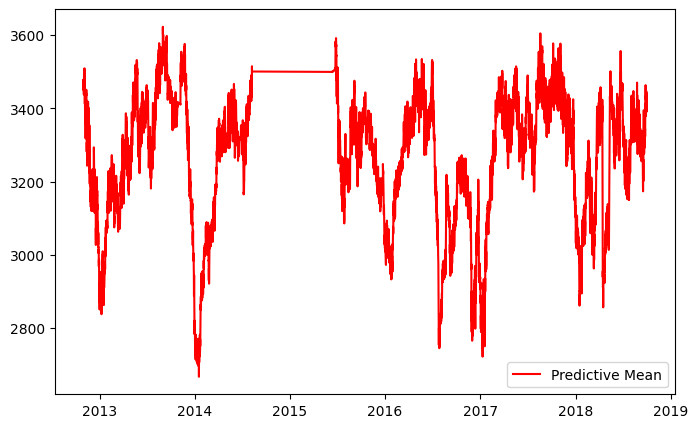

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(df['date_time'], df['traffic_volume'].rolling(window=30*24).mean(), 'r-', label='Predictive Mean')
plt.legend()
plt.show()

Length Scale = 0.1, Period = 8760, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE: 1926.850566887171
Test RMSE: 1985.6618697804624


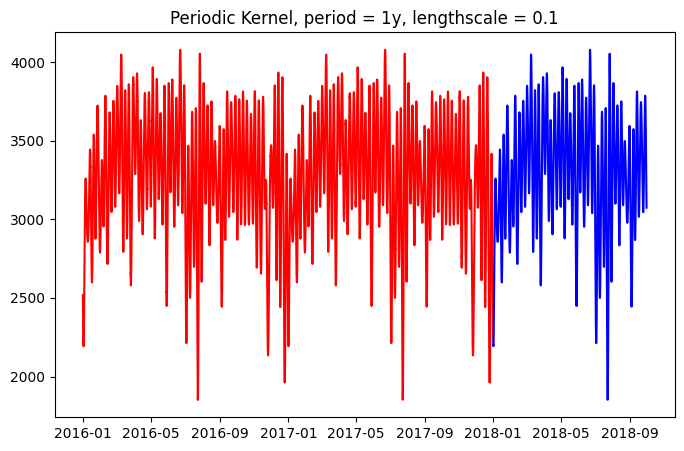

Length Scale = 1, Period = 8760, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE: 1962.645354920789
Test RMSE: 1977.3158143036483


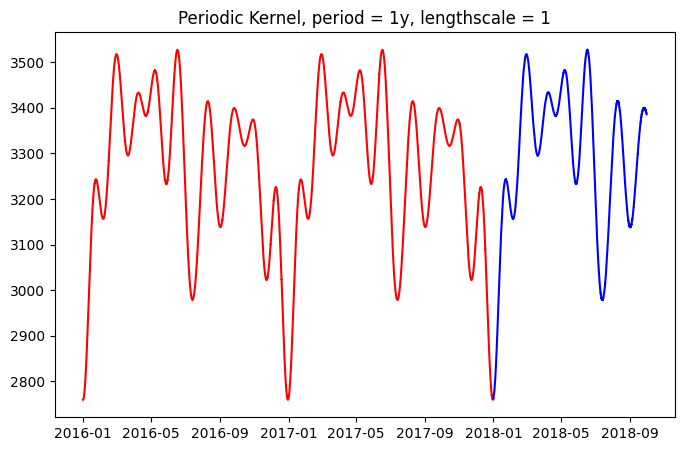

Length Scale = 10, Period = 8760, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE: 1965.6411851502291
Test RMSE: 1973.8715531455002


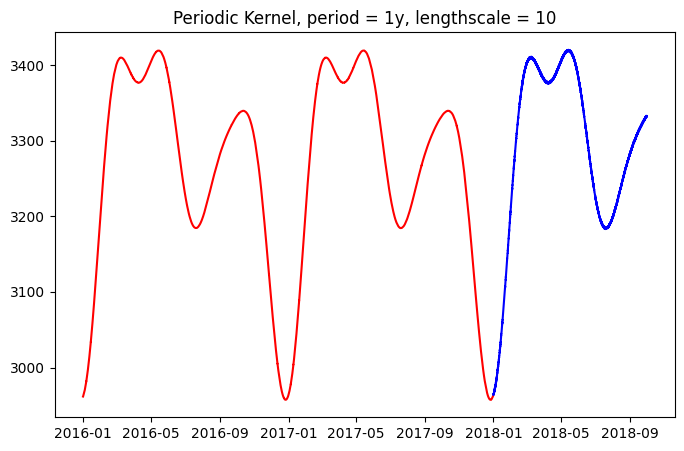

Length Scale = 100, Period = 8760, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE: 1966.2863092431257
Test RMSE: 1974.4614230980105


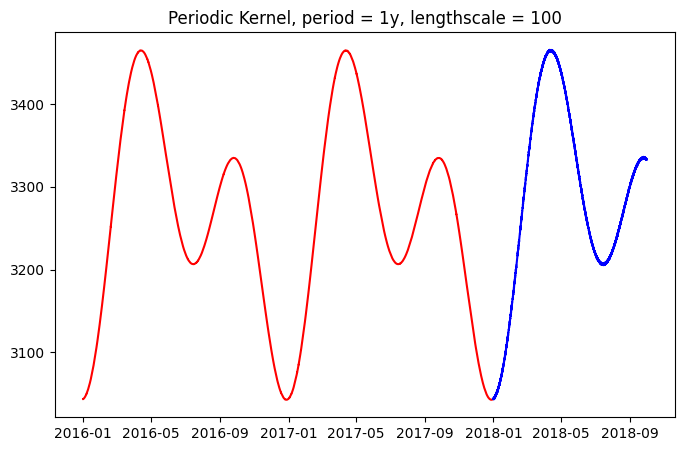

In [15]:
# 1 year periodicity
for l in [0.1, 1, 10, 100]:
    p = 24*365
    s = 1

    print(f'Length Scale = {l}, Period = {p}, Variance = {s}')
    mean_test, cov_test, mean_train, alpha, v = adj_gp_posterior(X_train, y_train, X_test, periodic_kernel, length_scale = l, period = p, variance = s)

    # get interval for test
    stdv = np.sqrt(np.diag(cov_test))
    upper = mean_test + 2 * stdv
    lower = mean_test - 2 * stdv

    train_rmse = rmse(y_train, mean_train)
    test_rmse = rmse(y_test, mean_test)

    print(f"Train RMSE: {train_rmse}")
    print(f"Test RMSE: {test_rmse}")

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(df_train['date_time'], mean_train, 'r-', label='Predictive Mean')
    plt.plot(df_test['date_time'], mean_test, 'b-', label='Predictive Mean')
    plt.title(f"Periodic Kernel, period = 1y, lengthscale = {l}")
    #plt.legend()
    plt.show()

Length Scale = 0.01, Period = 24, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE: 920.4572502488596
Test RMSE: 959.8506337026922


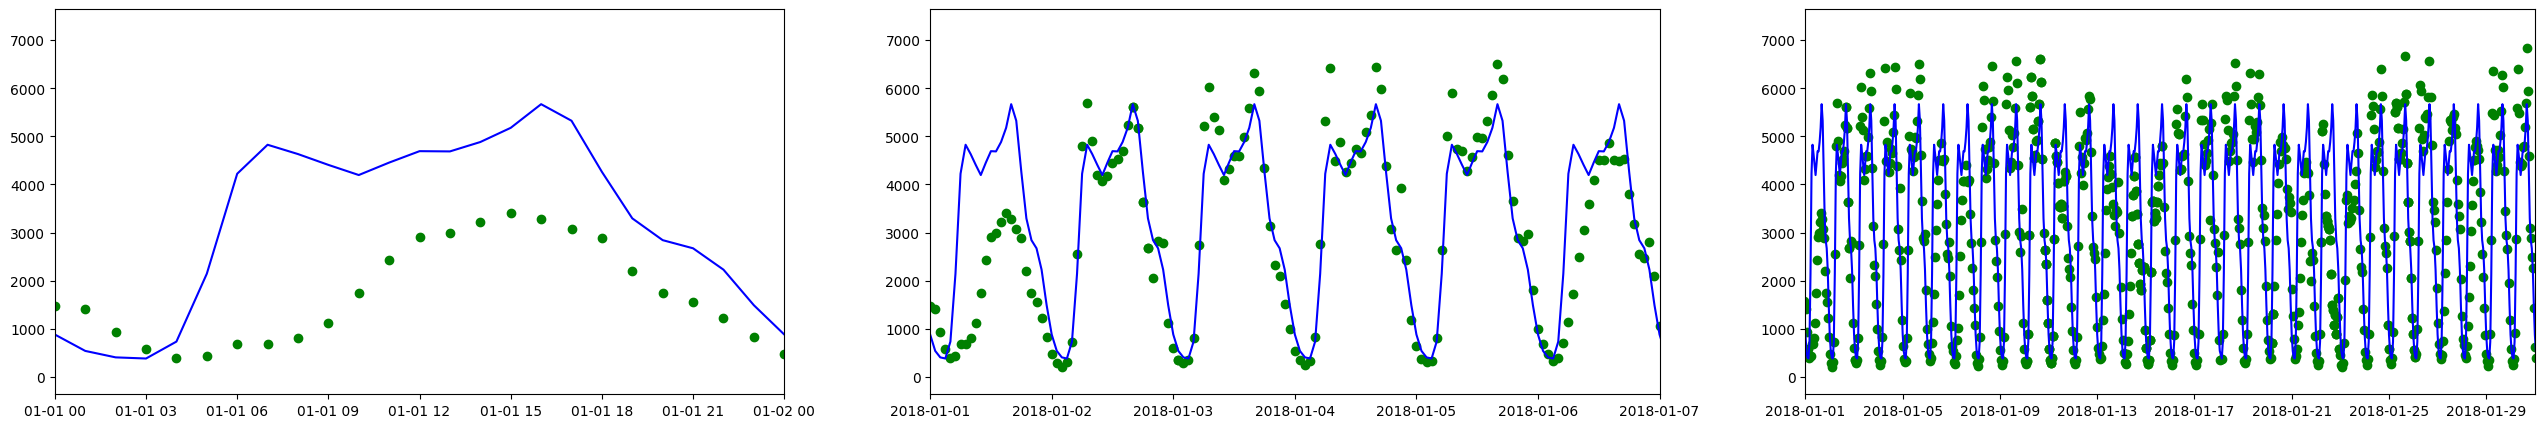

Length Scale = 0.1, Period = 24, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE: 920.4860395092536
Test RMSE: 959.8431108099549


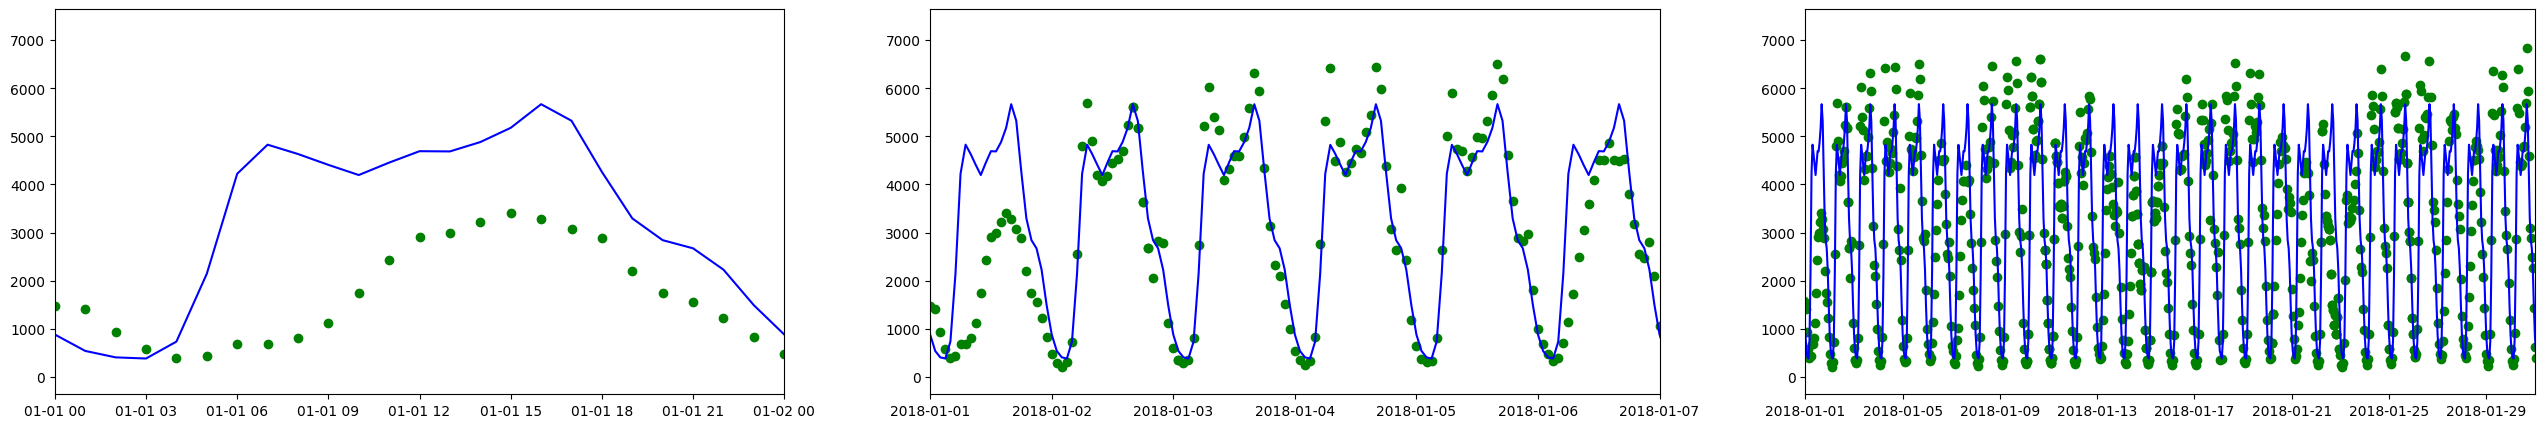

Length Scale = 1, Period = 24, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE: 920.5019147324789
Test RMSE: 959.8017383074799


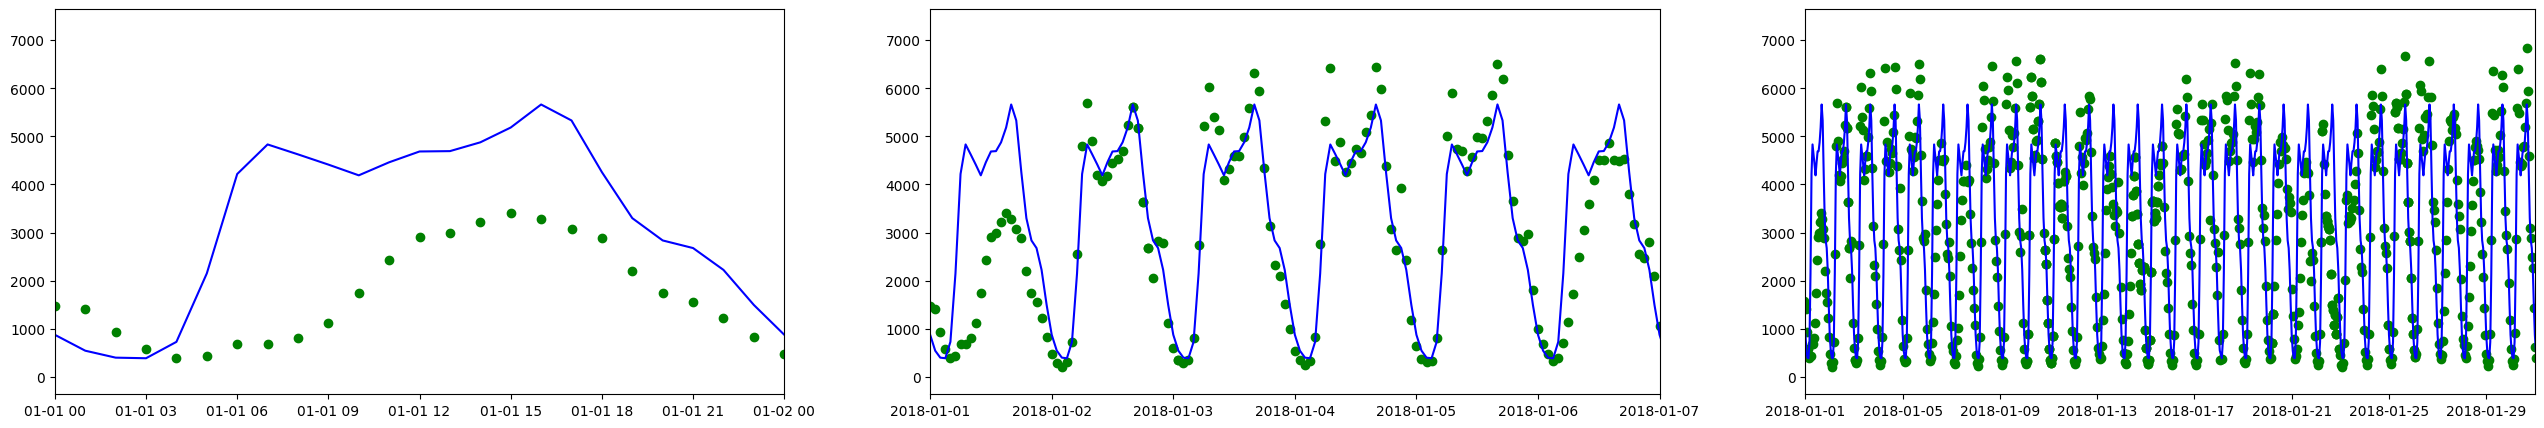

Length Scale = 10, Period = 24, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE: 950.5891538958072
Test RMSE: 984.6394823177922


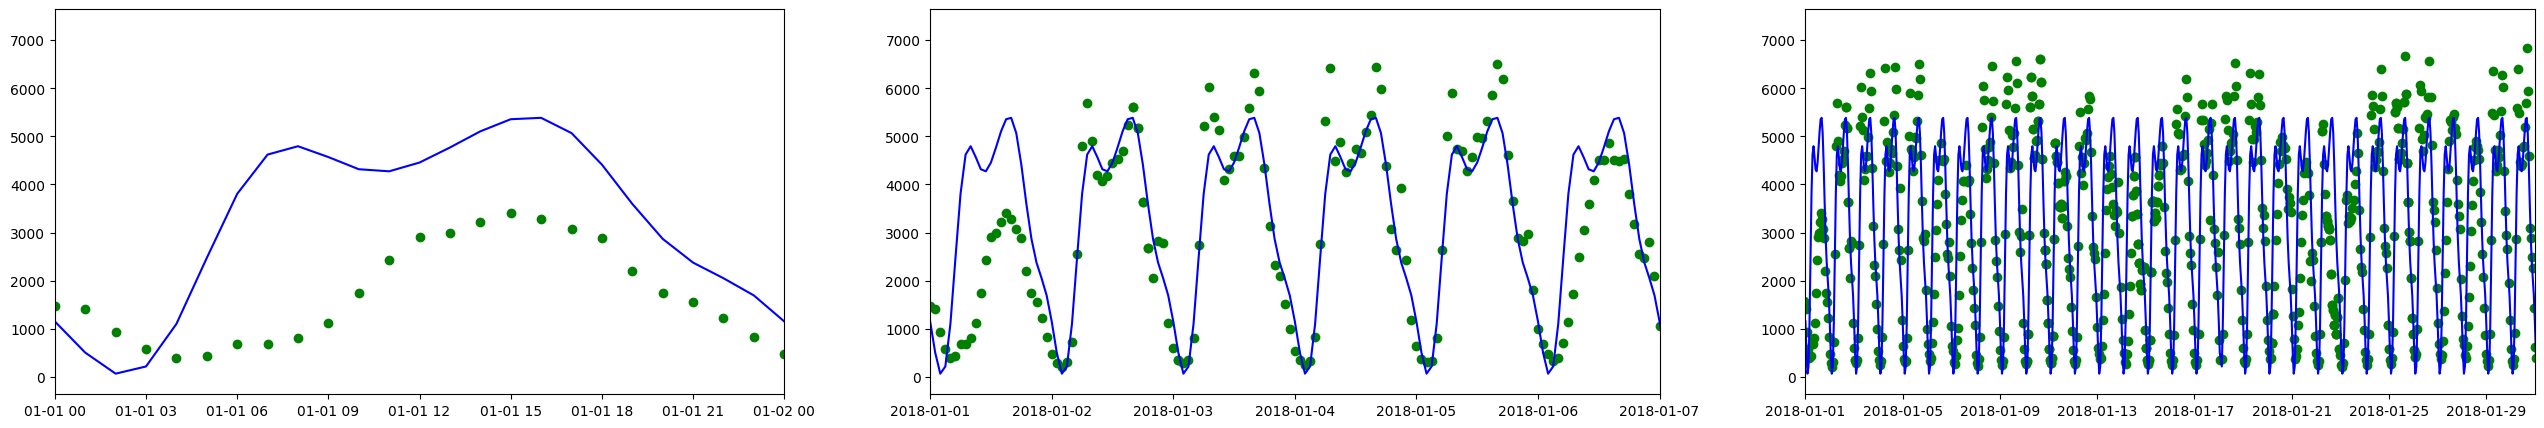

In [4]:
# 1 day periodicity
for l in [0.01, 0.1, 1, 10]:
    p = 24 # 24 hr
    s = 1

    print(f'Length Scale = {l}, Period = {p}, Variance = {s}')
    mean_test, cov_test, mean_train, alpha, v = adj_gp_posterior(X_train, y_train, X_test, periodic_kernel, length_scale = l, period = p, variance = s)

    # get interval for test
    stdv = np.sqrt(np.diag(cov_test))
    upper = mean_test + 2 * stdv
    lower = mean_test - 2 * stdv

    train_rmse = rmse(y_train, mean_train)
    test_rmse = rmse(y_test, mean_test)

    print(f"Train RMSE: {train_rmse}")
    print(f"Test RMSE: {test_rmse}")

    # Plot
    fig, ax = plt.subplots(1, 3, figsize = (32, 5))
    ax[0].plot(df['date_time'], df['traffic_volume'], 'go', label = 'True Data')
    ax[0].plot(df_train['date_time'], mean_train, 'r-', label='Predictive Mean')
    ax[0].plot(df_test['date_time'], mean_test, 'b-', label='Predictive Mean')
    ax[0].set_xlim(dt.datetime(2018, 1, 1), dt.datetime(2018, 1, 2)) # day

    ax[1].plot(df['date_time'], df['traffic_volume'], 'go', label = 'True Data')
    ax[1].plot(df_train['date_time'], mean_train, 'r-', label='Predictive Mean')
    ax[1].plot(df_test['date_time'], mean_test, 'b-', label='Predictive Mean')
    ax[1].set_xlim(dt.datetime(2018, 1, 1), dt.datetime(2018, 1, 7)) # week

    ax[2].plot(df['date_time'], df['traffic_volume'], 'go', label = 'True Data')
    ax[2].plot(df_train['date_time'], mean_train, 'r-', label='Predictive Mean')
    ax[2].plot(df_test['date_time'], mean_test, 'b-', label='Predictive Mean')
    ax[2].set_xlim(dt.datetime(2018, 1, 1), dt.datetime(2018, 1, 31)) # month
    #plt.legend()
    plt.show()

Length Scale = 0.1, Period = 168, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE: 504.2502112838889
Test RMSE: 524.0647542148128


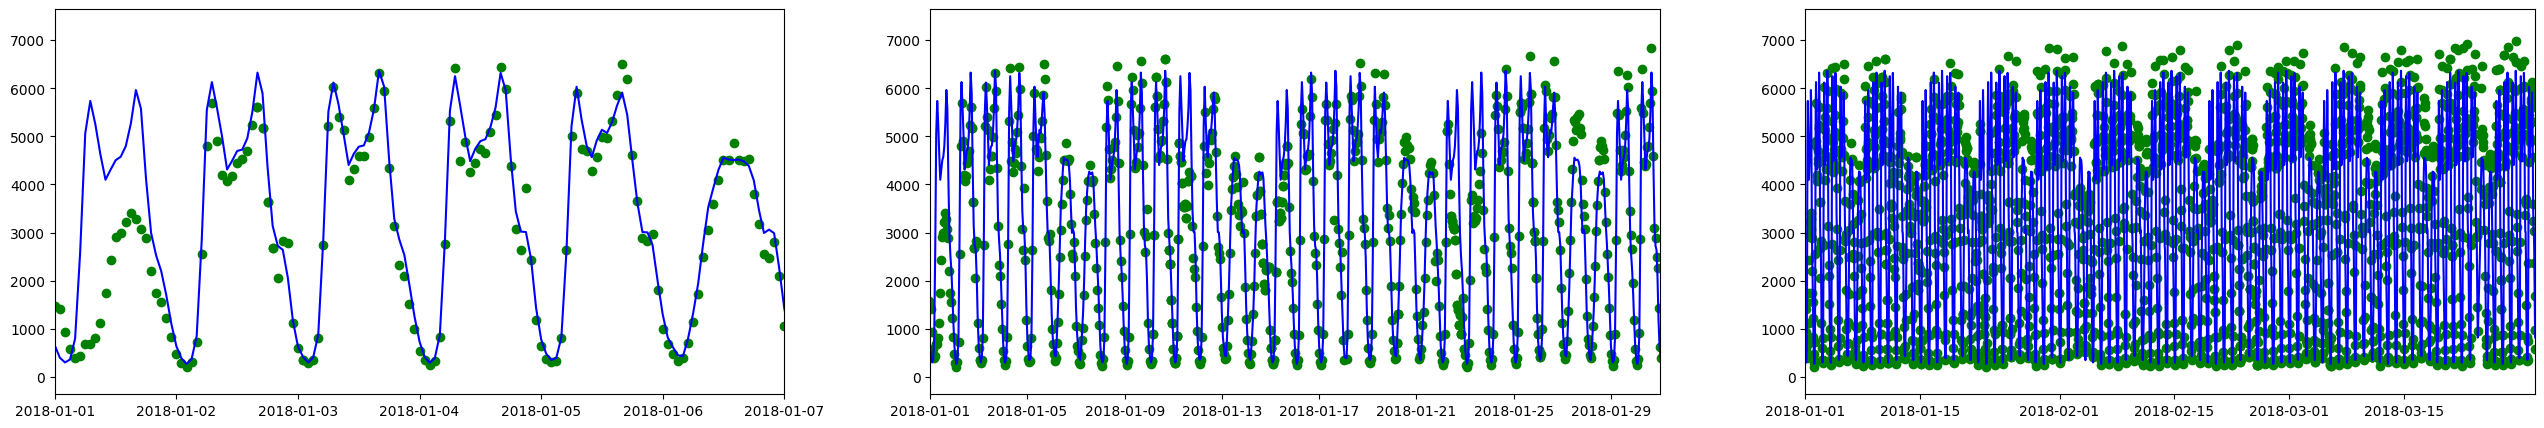

Length Scale = 1, Period = 168, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE: 1010.9311065378025
Test RMSE: 1017.5635771770341


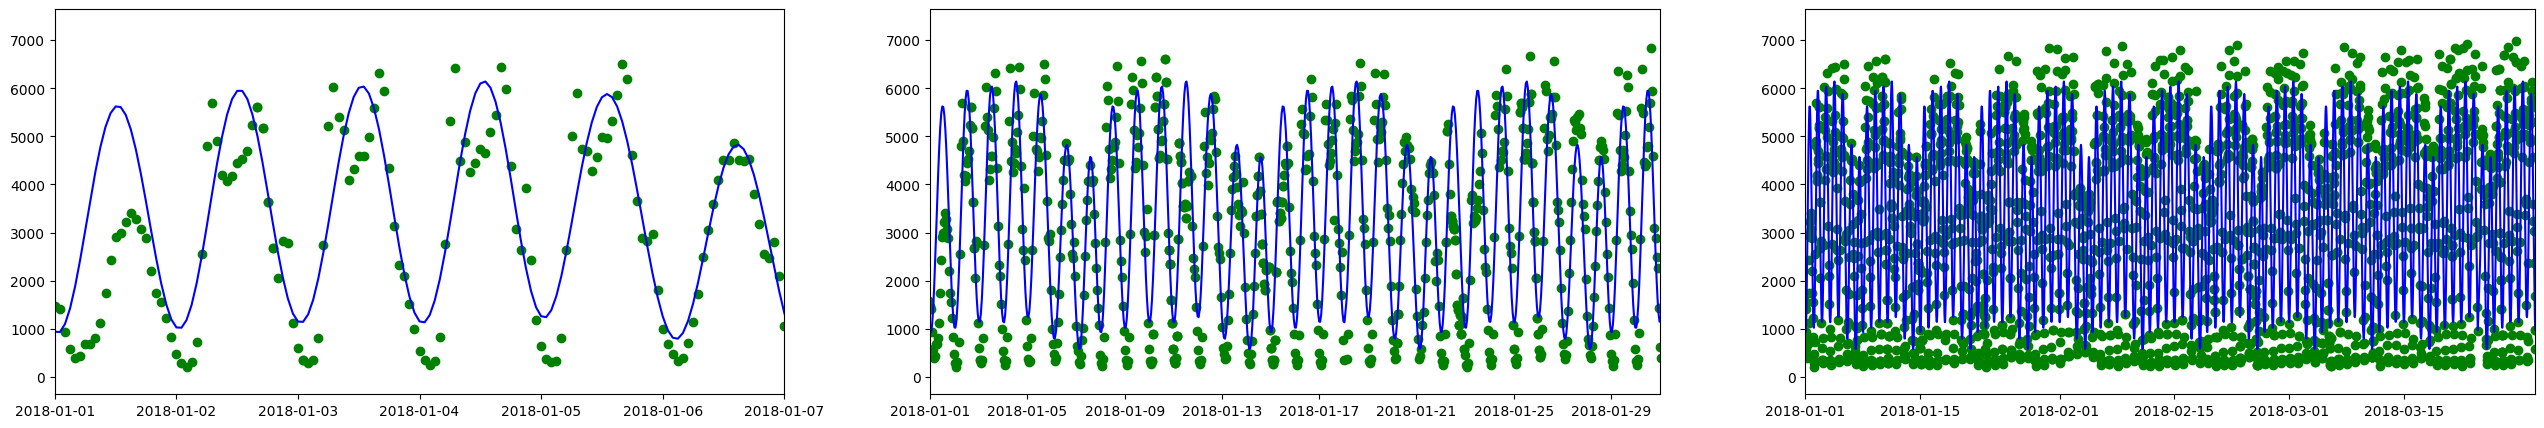

Length Scale = 10, Period = 168, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE: 1927.4020261651797
Test RMSE: 1924.7284494589878


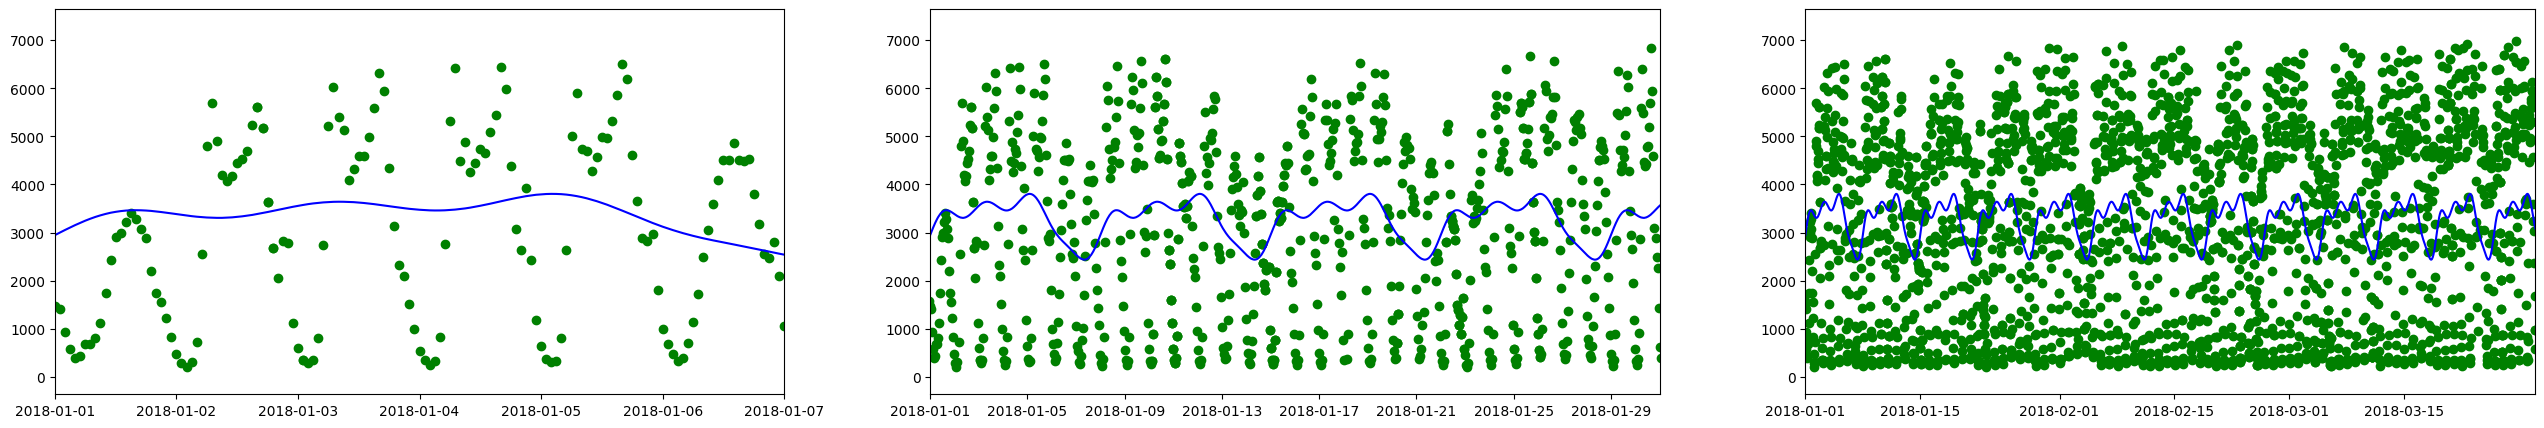

Length Scale = 100, Period = 168, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE: 1931.5891996802254
Test RMSE: 1926.3295483743468


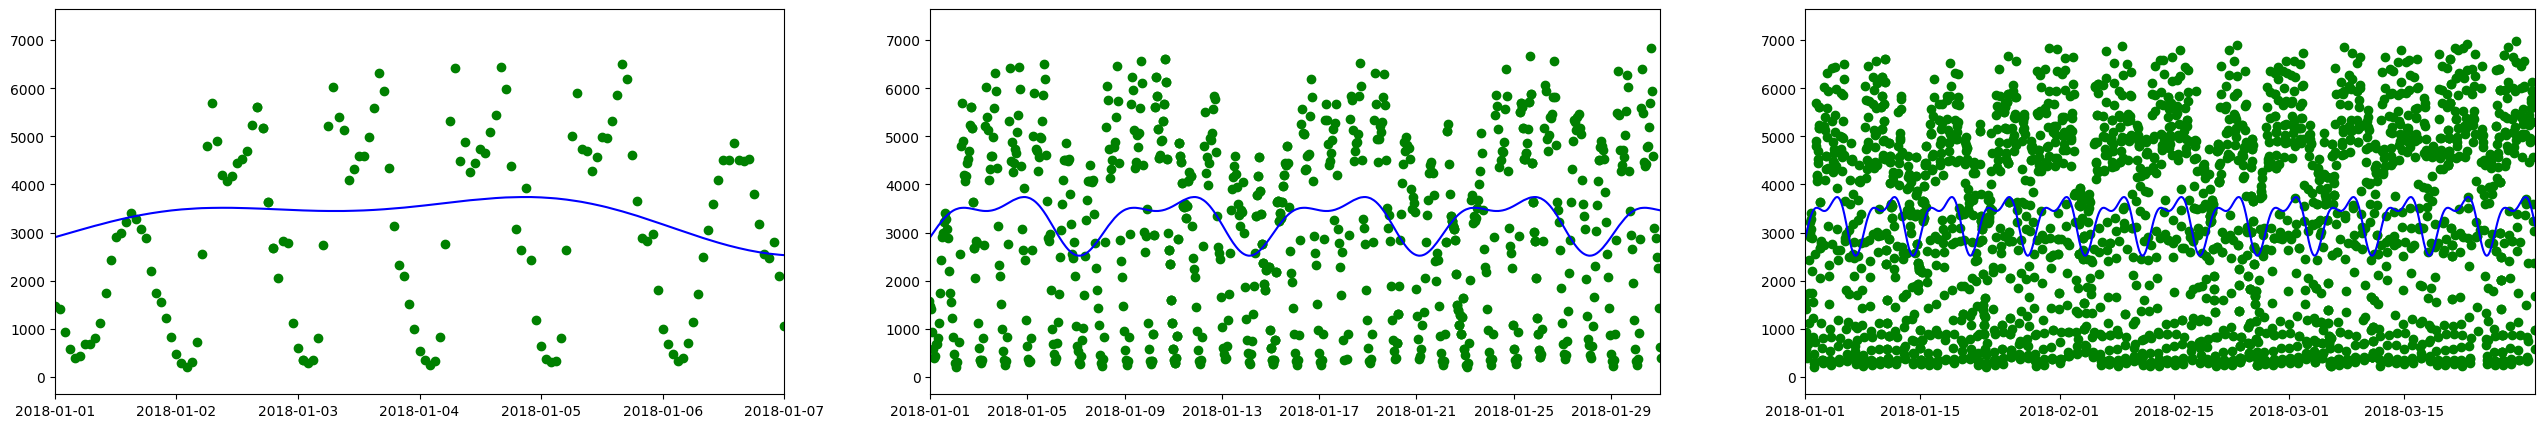

In [5]:
# 7 day periodicity
for l in [0.1, 1, 10, 100]:
    p = 7*24 # 24 hr
    s = 1

    print(f'Length Scale = {l}, Period = {p}, Variance = {s}')
    mean_test, cov_test, mean_train, alpha, v = adj_gp_posterior(X_train, y_train, X_test, periodic_kernel, length_scale = l, period = p, variance = s)

    # get interval for test
    stdv = np.sqrt(np.diag(cov_test))
    upper = mean_test + 2 * stdv
    lower = mean_test - 2 * stdv

    train_rmse = rmse(y_train, mean_train)
    test_rmse = rmse(y_test, mean_test)

    print(f"Train RMSE: {train_rmse}")
    print(f"Test RMSE: {test_rmse}")

    # Plot
    fig, ax = plt.subplots(1, 3, figsize = (32, 5))
    ax[0].plot(df['date_time'], df['traffic_volume'], 'go', label = 'True Data')
    ax[0].plot(df_train['date_time'], mean_train, 'r-', label='Predictive Mean')
    ax[0].plot(df_test['date_time'], mean_test, 'b-', label='Predictive Mean')
    ax[0].set_xlim(dt.datetime(2018, 1, 1), dt.datetime(2018, 1, 7)) # week

    ax[1].plot(df['date_time'], df['traffic_volume'], 'go', label = 'True Data')
    ax[1].plot(df_train['date_time'], mean_train, 'r-', label='Predictive Mean')
    ax[1].plot(df_test['date_time'], mean_test, 'b-', label='Predictive Mean')
    ax[1].set_xlim(dt.datetime(2018, 1, 1), dt.datetime(2018, 1, 31)) # month

    ax[2].plot(df['date_time'], df['traffic_volume'], 'go', label = 'True Data')
    ax[2].plot(df_train['date_time'], mean_train, 'r-', label='Predictive Mean')
    ax[2].plot(df_test['date_time'], mean_test, 'b-', label='Predictive Mean')
    ax[2].set_xlim(dt.datetime(2018, 1, 1), dt.datetime(2018, 3, 31)) # 3 month
    #plt.legend()
    plt.show()